## This Notebook dedicated to build research work on imputing the Smart-Meter 6 hour interval and 15 minute interval data effectviely

### We have previously tested

1) Simple foreward fill propogating the last known value forward
2) Linear interpolation assuming the consective consumptions are relatively smooth
3) Spline interpolation assuming complex structures of consumption
4) Polynomial interpolation
5) Moving Average

But since those methods doesnt consider the household information, we are hoping to establish a robust imputing methodlogy incorporating such household data

The below graph shows the current datapoint density graph for Smart-meter 15 min interval dataset

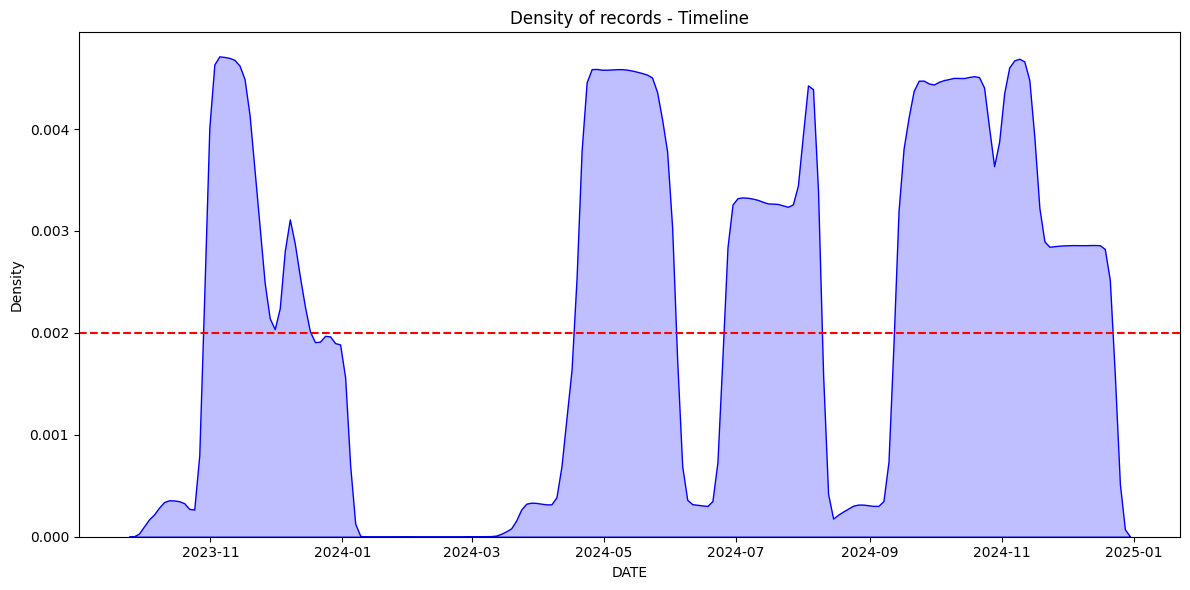

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

all_data = pd.DataFrame()
total = 0

wave_1_houseinfo = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_household_information_and_history.csv')
wave_1_houseinfo = wave_1_houseinfo[['household_ID', 'socio_economic_class', 'no_of_household_members']]

for root, folder, files in os.walk('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/consumption_data/smart_meter/15min_interval'):
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            data = pd.read_csv(file_path, low_memory=False)
            all_data = pd.concat([all_data, data], ignore_index=True)
            rows, cols = data.shape
            total = total + rows

all_data_filtered = all_data[['household_ID', 'date', 'time', 'importkwh(kwh)', 'exportkwh(kwh)']].copy()
all_data_filtered = all_data_filtered[all_data_filtered['household_ID'].isin(wave_1_houseinfo['household_ID'])]

all_data_filtered['time'] = all_data_filtered['time'].str.extract(r'(\d{2}:\d{2}:\d{2})')

all_data_filtered['DATETIME'] = pd.to_datetime(all_data_filtered['date'] + ' ' + all_data_filtered['time'], errors='coerce')

all_data_filtered['importkwh(kwh)'] = pd.to_numeric(all_data_filtered['importkwh(kwh)'], errors='coerce')
all_data_filtered['exportkwh(kwh)'] = pd.to_numeric(all_data_filtered['exportkwh(kwh)'], errors='coerce')

all_data_filtered = all_data_filtered.sort_values(['household_ID', 'DATETIME'])

all_data_filtered[['importkwh(kwh)', 'exportkwh(kwh)']] = (
    all_data_filtered.groupby('household_ID')[['importkwh(kwh)', 'exportkwh(kwh)']].diff()
)

negatives = all_data_filtered[
    (all_data_filtered['importkwh(kwh)'] < 0) |
    (all_data_filtered['exportkwh(kwh)'] < 0)
]

all_data_filtered = all_data_filtered.drop(negatives.index)

# Kernel Density Estimation (KDE) probability density function

plt.figure(figsize=(12, 6))
density_threshold = 0.002

sns.kdeplot(all_data_filtered['DATETIME'], fill=True, color='blue', bw_adjust=0.5)
plt.axhline(y=density_threshold, color='red', linestyle='--', label='Density Threshold = 0.002')
plt.title('Density of records - Timeline')
plt.xlabel('DATE')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

### Step 01: Creating a Dataset of complete 15 min interval timepoints for all the households and merging our current dataset into it

In [41]:
all_data_filtered = all_data_filtered.sort_values(['household_ID', 'DATETIME'])

def create_complete_dataset_vectorized(data):
    
    households = data['household_ID'].unique()
    min_date = data['DATETIME'].min()
    max_date = data['DATETIME'].max()
    full_time_index = pd.date_range(start=min_date, end=max_date, freq='15T')
    full_index = pd.MultiIndex.from_product([households, full_time_index], names=['household_ID', 'DATETIME'])
    full_df = pd.DataFrame(index=full_index).reset_index()

    return pd.merge(full_df, data, on=['household_ID', 'DATETIME'], how='left')

complete_data = create_complete_dataset_vectorized(all_data_filtered)

'''#creating a complete dataset interms of date and time
def create_complete_dataset(data):
    all_data = pd.DataFrame()
    households = data['household_ID'].unique()

    for household in households:
        household_data = data[data['household_ID'] == household]
        date_range = pd.date_range(start=household_data['DATETIME'].min(), end=household_data['DATETIME'].max(), freq='15T')
        complete_data = pd.DataFrame({'DATETIME': date_range})
        complete_data['household_ID'] = household
        complete_data = pd.merge(complete_data, household_data, on=['household_ID', 'DATETIME'], how='left')
        all_data = pd.concat([all_data, complete_data], ignore_index=True)

    return all_data

complete_data = create_complete_dataset(all_data_filtered)'''

/var/folders/qq/v15mxgl96rjgk1x2qkhfzvlh0000gn/T/ipykernel_25759/3478734121.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_time_index = pd.date_range(start=min_date, end=max_date, freq='15T')


"#creating a complete dataset interms of date and time\ndef create_complete_dataset(data):\n    all_data = pd.DataFrame()\n    households = data['household_ID'].unique()\n\n    for household in households:\n        household_data = data[data['household_ID'] == household]\n        date_range = pd.date_range(start=household_data['DATETIME'].min(), end=household_data['DATETIME'].max(), freq='15T')\n        complete_data = pd.DataFrame({'DATETIME': date_range})\n        complete_data['household_ID'] = household\n        complete_data = pd.merge(complete_data, household_data, on=['household_ID', 'DATETIME'], how='left')\n        all_data = pd.concat([all_data, complete_data], ignore_index=True)\n\n    return all_data\n\ncomplete_data = create_complete_dataset(all_data_filtered)"

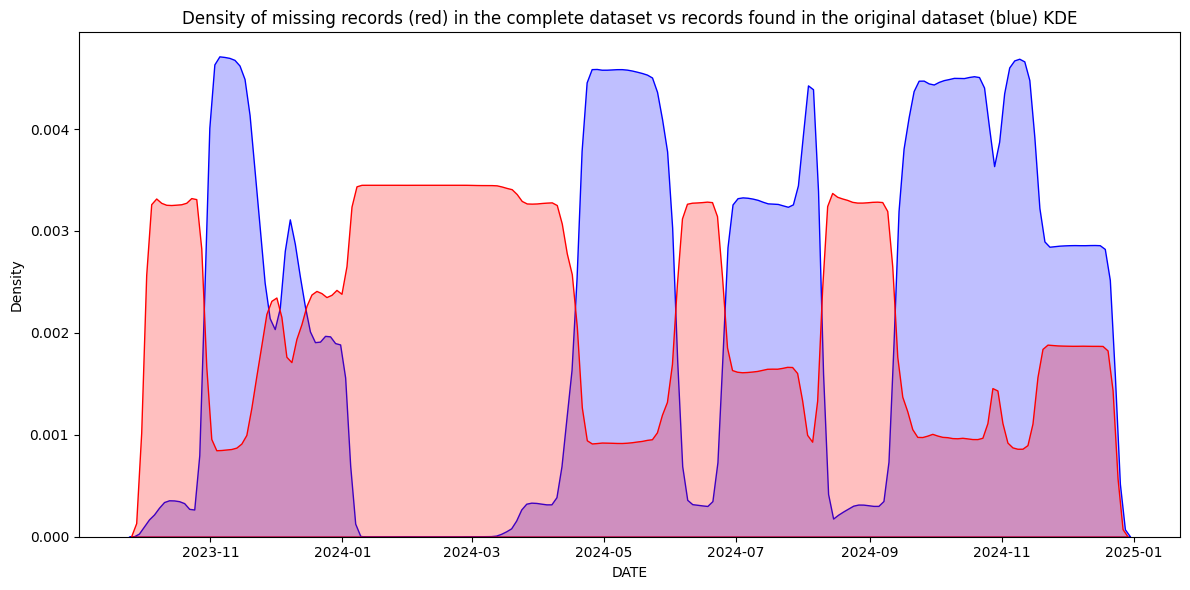

In [42]:
plt.figure(figsize=(12, 6))
sns.kdeplot(all_data_filtered['DATETIME'].dropna(), fill=True, color='blue', bw_adjust=0.5)
sns.kdeplot(complete_data[complete_data['importkwh(kwh)'].isna()]['DATETIME'], fill=True, color='red', bw_adjust=0.5)
plt.title('Density of missing records (red) in the complete dataset vs records found in the original dataset (blue) KDE')
plt.xlabel('DATE')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

### Step 02: Filling Missing Data Points Using Interpolation Based on Household Characteristics

To fill in the missing consumption data between two known data points, we construct a consumption weights dictionary for each hour of the day. This dictionary considers, the number of household members and the socio-economic class of the household. These weights are then used to distribute the missing consumption proportionally across the time interval.


#### Step 02.01: Creating weight dictionary


In [50]:
# selecting a most dense period of time for creating the imputation model

# from the all_data_filtered select data from 2024-09 to 2024-12
all_data_dense = all_data_filtered[all_data_filtered['DATETIME'] >= '2024-09-01']

# remove the first datapoint of every households
all_data_dense = all_data_dense[~all_data_dense['DATETIME'].isin(all_data_dense.groupby('household_ID')['DATETIME'].first())]

In [51]:
# Removing rows if importkwh(kwh) > 50 
all_data_dense = all_data_dense[all_data_dense['importkwh(kwh)'] <= 20]

#### Step 02.01.01: Creating weight dictionary for consumption

<Axes: xlabel='time'>

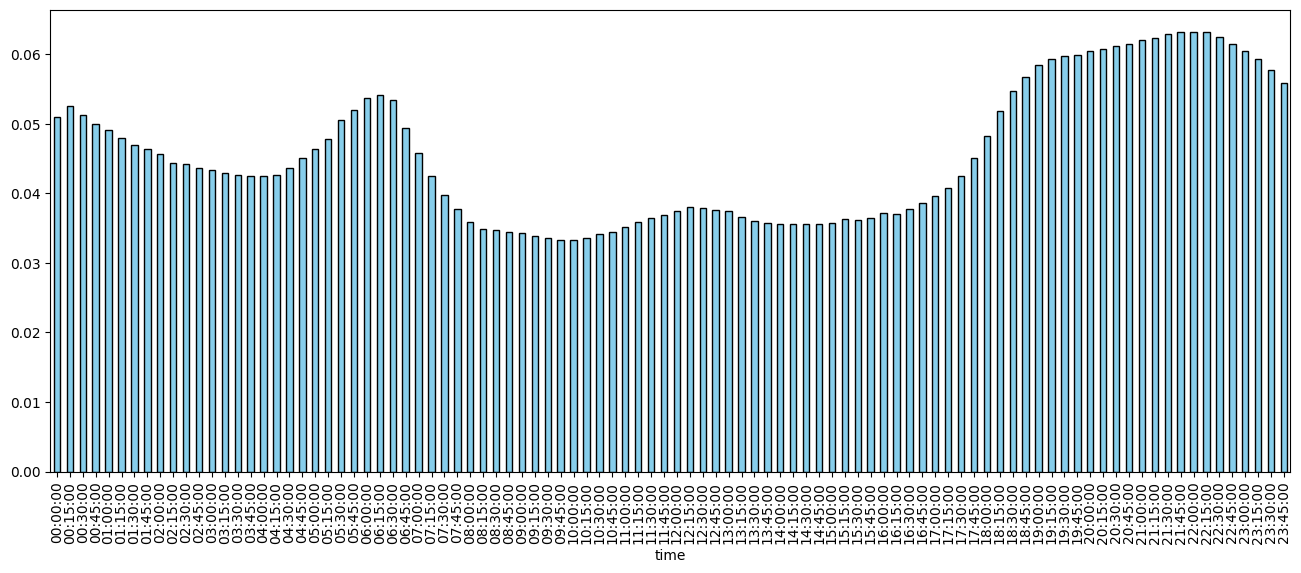

In [58]:
filtered_for_import = all_data_dense[all_data_dense['exportkwh(kwh)'] == 0]
daily_import = filtered_for_import.groupby('time')['importkwh(kwh)'].mean()
# GETTING RID OF THE NOICE
daily_import.loc['00:00:00'] = 00.051
plt.figure(figsize=(16, 6))
daily_import.plot( kind='bar', color='skyblue', edgecolor='black')

#### Step 02.01.01: Creating weight dictionary for power export

<Axes: xlabel='time'>

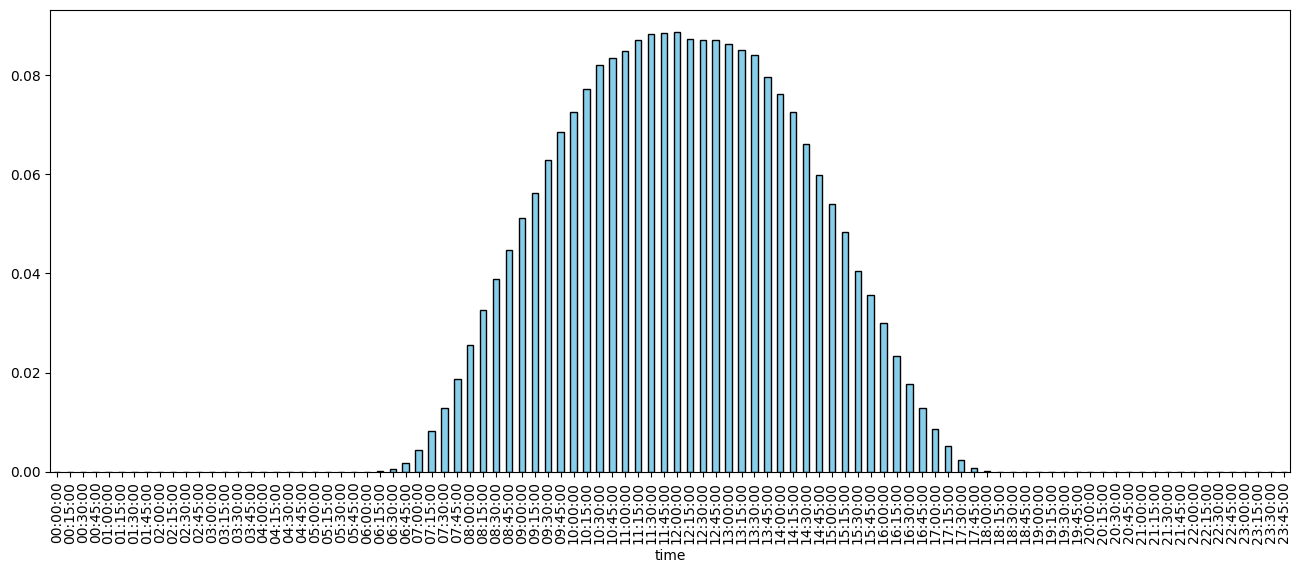

In [59]:
daily_export = all_data_dense.groupby('time')['exportkwh(kwh)'].mean()
# GETTING RID OF THE NOICE
daily_export.loc['00:00:00'] = 0
plt.figure(figsize=(16, 6))
daily_export.plot( kind='bar', color='skyblue', edgecolor='black')

In [55]:
# SET VALUE OF daily_import 00.00.00 TO 0
daily_import.loc['00:00:00'] = 0

time
00:00:00    6.866408e-03
00:15:00    1.413276e-07
00:30:00    1.234291e-07
00:45:00    1.534945e-07
01:00:00    1.328941e-07
                ...     
22:45:00    1.656908e-07
23:00:00    1.364028e-07
23:15:00    1.651134e-07
23:30:00    1.772951e-07
23:45:00    7.953578e-08
Name: exportkwh(kwh), Length: 96, dtype: float64